In [7]:
'''
Detailed analysis of the predictions
1. Runtime bracket
2. Probability change
3. Top 2 with runtime within 5% as correct
'''
%matplotlib inline

import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import matthews_corrcoef as mcc_fn
from sklearn.metrics import accuracy_score as acc_fn
import torch.nn.functional as F

# exp_dir = os.path.abspath("")

In [10]:
# Process the metric from multiple runs and save the mean+std results

def compute_metrics(preds, labels, thres):
    # Compute runtime (rt) and halt rate (hr) based on different halt rate thresholds.
    if labels.shape[1] > 7:
        runtime = labels[:, 2:-1]
    else:
        runtime = labels
    base_time = runtime[:, 0]
    min_time, _ = runtime.min(dim=1) 

    len_data = preds.shape[0]

    pred_top1 = preds.argmax(dim=1) # Predicted solver
    pred_time_top1 = runtime[torch.arange(len_data), pred_top1] 

    # Compute the better time among predicted top2 solvers
    _, pred_idx_top2 = torch.topk(preds, 2, dim=1)
    tmp = torch.zeros((len_data, 2))
    tmp[:, 0] = runtime[torch.arange(len_data), pred_idx_top2[:, 0]]
    tmp[:, 1] = runtime[torch.arange(len_data), pred_idx_top2[:, 1]]
    pred_time_top2, _ = tmp.min(dim=1)

    # Analyze the results based on bracket of min runtime
    mask = (min_time > thres[0]) & (min_time <= thres[1])
    percentage = mask.sum().float() / len_data

    # rt_top1 = pred_time_top1[top1_mask].mean()
    rt_top1 = pred_time_top1[mask].mean()
    rt_top2 = pred_time_top2[mask].mean()

    improvement_top1 = ((base_time - pred_time_top1) / base_time)[mask].mean()

    rt_min = min_time[mask].mean()
    rt_base = base_time[mask].mean()

    tgt_idx = runtime.argmin(dim=1)
    
    mcc = mcc_fn(tgt_idx[mask], pred_top1[mask])
    acc = acc_fn(tgt_idx[mask], pred_top1[mask])
    
    # Calculate equivalent accuracy. Prediction is correct if the runtime difference is < 5%
    equ_top1_corr = ((pred_time_top1-min_time) / min_time <= 0.05)
    equ_top1_acc = equ_top1_corr[mask].sum() / mask.sum()

    equ_top2_corr = ((pred_time_top2-min_time) / min_time <= 0.05)
    equ_top2_acc = equ_top2_corr[mask].sum() / mask.sum()

    # Expected runtime
    probs = F.softmax(preds, dim=-1)
    exp_rt_all = (runtime * probs).sum(dim=1)
    exp_rt = exp_rt_all[mask].mean()
    return {'percentage': percentage, 'rt_base': rt_base, 'rt_min': rt_min, 'exp_rt': exp_rt, 'rt_top1': rt_top1, 'rt_top2': rt_top2,
            'mcc': mcc, 'acc': acc, 'equ_top1_acc': equ_top1_acc, 'equ_top2_acc': equ_top2_acc, 'improvement_top1': improvement_top1}

def process_metrics(exp_dir):
    # hr_options = [100, 200, 300, 400, 500]
    exp_name = exp_dir.split('/')[-1]
    print(f"exp_name: {exp_name}")
    hr_options = [(0, 100), (100, 200), (200, 300), (300, 400), (400, 500), (500, np.inf)]
    data = []
    for split_idx in range(5):
        run_dir = os.path.join(exp_dir, 'seed_604_split_'+str(split_idx))
        test_label_file = os.path.join(run_dir, 'test_labels.csv')
        test_pred_file = os.path.join(run_dir, 'test_pred_probs.csv')

        if not os.path.isfile(test_pred_file):
            continue

        labels = pd.read_csv(test_label_file).to_numpy()
        preds = pd.read_csv(test_pred_file).to_numpy()

        labels = torch.tensor(labels)
        preds = torch.tensor(preds)

        test_metrics_list = []
        
        for hr_threshold in hr_options:
            metrics = compute_metrics(preds, labels, hr_threshold)
            test_metrics_list.append(metrics)

        row_index = [str(rt_range) for rt_range in hr_options]
        # print(row_index)
        test_metrics = pd.DataFrame.from_records(test_metrics_list, index=row_index).astype(float)
        save_path = os.path.join(run_dir, 'test_metrics_v3.csv')
        test_metrics.to_csv(save_path)

        data.append(test_metrics)

    print(data)
    data_arr = np.dstack([d.to_numpy() for d in data])

    avg = data_arr.mean(axis=2).round(3)
    std = data_arr.std(axis=2).round(3)

    new_df = pd.DataFrame(index=data[0].index, columns=data[0].columns)
    
    for j, col in enumerate(new_df.columns):
        dat = []
        for i in range(avg.shape[0]):
            avg_std = str(avg[i, j]) + str(u"\u00B1") + str(std[i, j])
            dat.append(avg_std)
        new_df[col] = dat
    
    save_path = os.path.join(exp_dir, exp_name+'_min_rt_range.csv')
    new_df.to_csv(save_path, encoding='utf-8-sig')
    print(new_df)

dirs = {
    'SATzilla': "/home/vincent/sat/sat_selection_light/lightning_logs/0604_satzilla_mlp",   # Raw logs in baselines/ directory
    'GCN-LPE': "/home/vincent/sat/sat_selection_light/lightning_logs/0608_solv-none",
    'Hetero-LPE': "/home/vincent/sat/sat_selection_light/lightning_logs/0802_hetero_logits",
    'Hetero-Nodezilla': "/home/vincent/sat/sat_selection_light/lightning_logs/0808_hetero_satzilla_feat"
}

for _, exp_dir in dirs.items():
    process_metrics(exp_dir)

exp_name: 0604_satzilla_mlp
[            percentage     rt_base      rt_min      exp_rt     rt_top1  \
(0, 100)      0.157945  111.767591   70.149176   97.239790   88.070768   
(100, 200)    0.211419  208.000601  146.851307  189.620106  166.634425   
(200, 300)    0.215928  364.793824  250.580882  331.508892  296.295882   
(300, 400)    0.166900  472.210426  345.279680  461.328270  422.538052   
(400, 500)    0.108472  582.570258  446.531616  608.839764  549.467799   
(500, inf)    0.139337  754.623063  637.096171  826.129954  735.632179   

               rt_top2       mcc       acc  equ_top1_acc  equ_top2_acc  \
(0, 100)     75.298752  0.257055  0.507439      0.601126      0.833936   
(100, 200)  151.601685  0.270363  0.603785      0.681886      0.908081   
(200, 300)  266.874695  0.175300  0.538824      0.599706      0.814706   
(300, 400)  376.873657  0.109937  0.393075      0.463470      0.695967   
(400, 500)  489.075531  0.126917  0.375878      0.435012      0.687354   
(500, in

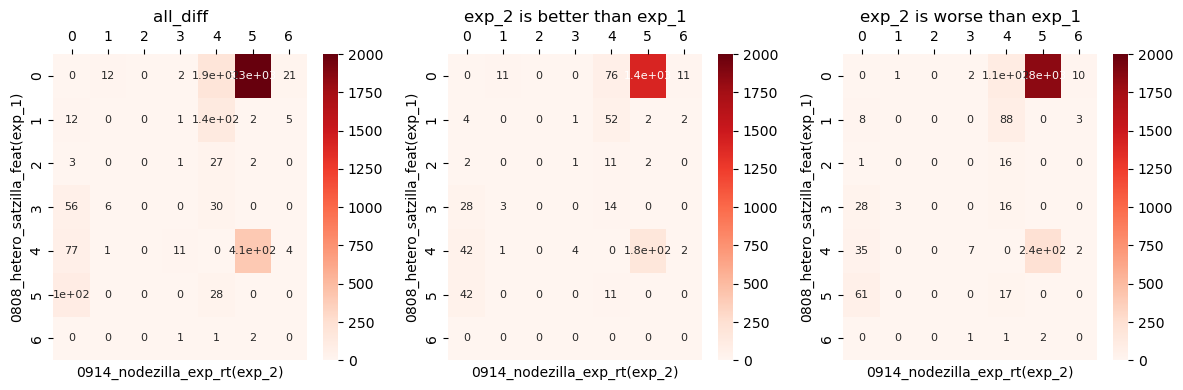

Total test data: 15746
Ratio of diff in total: 0.280
Avg. Runtime of diff pred: 16.542
Median runtime of diff pred: 7.000
Ratio of better in diff: 0.433
Avg. Runtime of better pred: -88.627
Median runtime of better pred: -46.000
Ratio of worse in diff: 0.567
Avg. Runtime of worse pred: 97.007
Median runtime of worse pred: 47.000



In [3]:
import os
import torch.nn.functional as F
import numpy as np
import torch
import pandas as pd
import seaborn as sbn
import matplotlib.pyplot as plt
# import plotly.express as px

log_dir = "/home/vincent/sat/sat_selection_light/lightning_logs/"

def compare_model_predictions(exp_1, exp_2):
    # hr_options = [100, 200, 300, 400, 500]

    exp_dir_1 = os.path.join(log_dir, exp_1)
    exp_dir_2 = os.path.join(log_dir, exp_2)

    results = []
    total_data_len = 0
    
    for split_idx in range(5):
        split_dir_1 = os.path.join(exp_dir_1, 'seed_604_split_'+str(split_idx))
        label_file_1 = os.path.join(split_dir_1, 'test_labels.csv')
        pred_file_1 = os.path.join(split_dir_1, 'test_pred_probs.csv')

        split_dir_2 = os.path.join(exp_dir_2, 'seed_604_split_'+str(split_idx))
        label_file_2 = os.path.join(split_dir_2, 'test_labels.csv')
        pred_file_2 = os.path.join(split_dir_2, 'test_pred_probs.csv')

        if not (os.path.isfile(pred_file_1) and os.path.isfile(pred_file_2)):
            continue

        labels_1 = pd.read_csv(label_file_1).to_numpy()
        if labels_1.shape[1] == 10:
            runtimes_1 = labels_1[:, 2:-1]
        else:
            runtimes_1 = labels_1
        preds_1 = F.softmax(torch.tensor(pd.read_csv(pred_file_1).to_numpy()), dim=-1).numpy()
        preds_1_top1 = np.argmax(preds_1, -1)
        index_arr = np.arange(preds_1.shape[0])
        rt_1_top1 = runtimes_1[index_arr, preds_1_top1]

        total_data_len += preds_1.shape[0]

        labels_2 = pd.read_csv(label_file_2).to_numpy()
        if labels_2.shape[1] == 10:
            runtimes_2 = labels_2[:, 2:-1]
        else:
            runtimes_2 = labels_2
        preds_2 = F.softmax(torch.tensor(pd.read_csv(pred_file_2).to_numpy()), dim=-1).numpy()
        preds_2_top1 = np.argmax(preds_2, -1)
        rt_2_top1 = runtimes_2[index_arr, preds_2_top1]

        # nodezilla_labels = pd.read_csv(nodezilla_test_label_file).to_numpy()
        # nodezilla_runtimes = nodezilla_labels[:, 2:-1]
        # nodezilla_preds = F.softmax(torch.tensor(pd.read_csv(nodezilla_test_pred_file).to_numpy()), dim=-1).numpy()
        # nodezilla_preds_top1 = np.argmax(nodezilla_preds, -1)
        # nodezilla_rt_top1 = nodezilla_runtimes[index_arr, nodezilla_preds_top1]

        diff_mask = rt_2_top1 != rt_1_top1
        better_mask = rt_2_top1[diff_mask] < rt_1_top1[diff_mask]
        worse_mask = rt_2_top1[diff_mask] > rt_1_top1[diff_mask]

        num_lit = labels_2[:, 0][diff_mask]
        num_clause = labels_2[:, 1][diff_mask]

        diff_pred_1 = preds_1_top1[diff_mask]
        diff_pred_2 = preds_2_top1[diff_mask]
        diff_rt_1 = rt_1_top1[diff_mask]
        diff_rt_2 = rt_2_top1[diff_mask]
        diff_rt = diff_rt_2 - diff_rt_1

        # impr_rt = base_rt_top1[diff_mask] - nodezilla_rt_top1[diff_mask]
        # impr_base_pred = base_preds_top1[diff_mask]
        # impr_base_prob = base_preds[index_arr, base_preds_top1][diff_mask]
        # impr_nz_pred = nodezilla_preds_top1[diff_mask]
        # impr_nz_prob = nodezilla_preds[index_arr, nodezilla_preds_top1][diff_mask] 
        # impr_base_pred_prob_change = (nodezilla_preds[index_arr, base_preds_top1] - base_preds[index_arr, base_preds_top1])[diff_mask]
        # impr_nz_pred_prob_change = (nodezilla_preds[index_arr, nodezilla_preds_top1] - base_preds[index_arr, nodezilla_preds_top1])[diff_mask]

        diff_data = np.stack([num_lit, num_clause, better_mask, worse_mask, diff_pred_1, diff_rt_1, diff_pred_2, diff_rt_2, diff_rt], axis=-1)
        results.append(diff_data)
        
        # preds = np.stack([base_preds_top1, nodezilla_preds_top1], axis=-1)

        # df_preds = pd.DataFrame(preds, columns=['base', 'nodezilla'])
        # fig = px.density_heatmap(df_preds, nbinsx=7, nbinsy=7, x="base", y="nodezilla", range_x=[-0.5, 6.5], range_y=[-0.5, 6.5], marginal_x="histogram", marginal_y="histogram")
        # fig.write_image(os.path.join(nodezilla_run_dir, 'label_change_'+str(split_idx)+'.png'))
    
    all_results = np.concatenate(results, axis=0)
    df_res = pd.DataFrame(all_results, columns=['num_lit', 'num_clause', 'is_better', 'is_worse', 'pred_1', 'rt_1', 'pred_2', 'rt_2', 'diff_rt'])

    def get_label_change_matrix(df_res, key=None):
        if key != None:
            data = df_res[df_res[key]==1.0]
        else:
            data = df_res
        label_change = data.groupby(['pred_1', 'pred_2'], as_index=False)['num_lit'].count()
        label_matrix = np.zeros((7, 7))
        for _, row in label_change.iterrows():
            idx_1 = int(row['pred_1'])
            idx_2 = int(row['pred_2'])
            label_matrix[idx_1, idx_2] = row['num_lit']
        # print(label_matrix)
        df_matrix = pd.DataFrame(label_matrix)
        return df_matrix

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    diff_rt_mean = df_res['diff_rt'].mean()
    diff_rt_median = df_res['diff_rt'].median()
    diff_label_matrix = get_label_change_matrix(df_res) 
    diff_savepath = os.path.join(exp_dir_2, f'vs_{exp_1}_diff_label.csv')
    diff_label_matrix.to_csv(diff_savepath)

    sbn.heatmap(diff_label_matrix, vmax=2e3, cmap='Reds', annot=True, annot_kws={'fontsize':8}, ax=axes[0])
    axes[0].set(xlabel=exp_2+'(exp_2)', ylabel=exp_1+'(exp_1)', title='all_diff')
    axes[0].xaxis.tick_top()
    # plt.savefig(''.join(diff_savepath.split('.')[:-1])+'.png')
    # plt.show()
    # plt.close()

    better_cnt = df_res['is_better'].sum() 
    better_ratio = better_cnt / df_res.shape[0]
    better_rt_mean = df_res[df_res['is_better']==1.0]['diff_rt'].mean()
    better_rt_median = df_res[df_res['is_better']==1.0]['diff_rt'].median()
    better_label_matrix = get_label_change_matrix(df_res, 'is_better') 
    better_savepath = os.path.join(exp_dir_2, f'vs_{exp_1}_better_label.csv')
    better_label_matrix.to_csv(better_savepath)

    # print(better_label_matrix.iloc[0, 3])
    sbn.heatmap(better_label_matrix, vmax=2e3, cmap='Reds', annot=True, annot_kws={'fontsize':8}, ax=axes[1])
    axes[1].set(xlabel=exp_2+'(exp_2)', ylabel=exp_1+'(exp_1)', title='exp_2 is better than exp_1')
    axes[1].xaxis.tick_top()
    # plt.savefig(''.join(better_savepath.split('.')[:-1])+'.png')
    # plt.close()

    worse_cnt = df_res['is_worse'].sum() 
    worse_ratio = worse_cnt / df_res.shape[0]
    worse_rt_mean = df_res[df_res['is_worse']==1.0]['diff_rt'].mean()
    worse_rt_median = df_res[df_res['is_worse']==1.0]['diff_rt'].median()
    worse_label_matrix = get_label_change_matrix(df_res, 'is_worse') 
    worse_savepath = os.path.join(exp_dir_2, f'vs_{exp_1}_worse_label.csv')
    worse_label_matrix.to_csv(worse_savepath)

    sbn.heatmap(worse_label_matrix, vmax=2e3, cmap='Reds', annot=True, annot_kws={'fontsize':8}, ax=axes[2])
    axes[2].set(xlabel=exp_2+'(exp_2)', ylabel=exp_1+'(exp_1)', title='exp_2 is worse than exp_1')
    axes[2].xaxis.tick_top()

    fig_savepath = os.path.join(exp_dir_2, f'vs_{exp_1}_preds.png')
    plt.tight_layout()
    plt.savefig(fig_savepath)
    plt.show()
    plt.close()


    # diff_rt_mean_neq_05 = df_res[(df_res['pred_2'] != 0) & (df_res['pred_2'] != 5)]['diff_rt'].mean()
    # print(diff_rt_mean_neq_05)
    # tmp2 = df_res[df_res['pred_2'] == 0]['diff_rt'].mean()
    # print(tmp2)
    # tmp3 = df_res[df_res['pred_2'] == 5]['diff_rt'].mean()
    # print(tmp3)

    diff_ratio = df_res.shape[0] / total_data_len
    str2save = f"Total test data: {total_data_len}\n" + \
               f"Ratio of diff in total: {diff_ratio:.3f}\n" + \
               f"Avg. Runtime of diff pred: {diff_rt_mean:.3f}\n" + \
               f"Median runtime of diff pred: {diff_rt_median:.3f}\n" + \
               f"Ratio of better in diff: {better_ratio:.3f}\n" + \
               f"Avg. Runtime of better pred: {better_rt_mean:.3f}\n" + \
               f"Median runtime of better pred: {better_rt_median:.3f}\n" + \
               f"Ratio of worse in diff: {worse_ratio:.3f}\n" + \
               f"Avg. Runtime of worse pred: {worse_rt_mean:.3f}\n" + \
               f"Median runtime of worse pred: {worse_rt_median:.3f}\n"

    print(str2save)
    with open(os.path.join(exp_dir_2, f'vs_{exp_1}_summary.txt'), 'w') as f:
        f.writelines(str2save)

    save_path = os.path.join(exp_dir_2, f'vs_{exp_1}_res.csv')
    df_res.to_csv(save_path)

# dirs = {
#     'SATzilla': "/home/vincent/sat/sat_selection_light/lightning_logs/0604_satzilla_mlp",   # Raw logs in baselines/ directory
#     'GCN-LPE': "/home/vincent/sat/sat_selection_light/lightning_logs/0608_solv-none",
#     'Hetero-LPE': "/home/vincent/sat/sat_selection_light/lightning_logs/0802_hetero_logits",
#     'Hetero-Nodezilla': "/home/vincent/sat/sat_selection_light/lightning_logs/0808_hetero_satzilla_feat"
# }
# exp_1 = '0604_satzilla_mlp'
exp_1 = '0808_hetero_satzilla_feat'
exp_2 = '0914_nodezilla_exp_rt'
# exp_2 = '0810_hetero_satzilla_feat_pe'

compare_model_predictions(exp_1, exp_2)